# Transportation distribution charges

Use pandas to calculate a transportation distribution charge for four gas meters in the United Kingdom.

_Transportation distribution charges are levied by gas distribution companies for the use of their lower pressure pipelines; they cover the cost of physically transporting the gas through the pipeline. This rate is determined depending on a meter's exit zone (gas network region) and its estimated annual quantity (AQ); and it changes over time._

The daily charge is calculated by finding the correct rate for each meter and day in the forecast and multiplying this rate (in p/kWh) with the day's forecast (in kWh).
- Calculate the __total cost per meter__ by summing its daily charges for the full forecast period and converting to Pounds (1p = 0.01£).
- Calculate the __total consumption per meter__ by summing its daily consumption forecast for the full period.

 > Example:
 >
 > Looking at meter __14676236__ with exit zone __EA1__ and an AQ of __28978 kWh__
 >
 > We can find the correct subset of rates in the rate table by selecting the correct exit zone and annual quantity band according to the meter properties. The AQ band is hereby determined by assuring the AQ is between the minimum AQ (aq_min_kwh, included) and the maximum AQ (aq_max_kwh, excluded, may be open-ended).

## Implementation

In this first part, I implement the aforementioned tasks. As a first step, the data is loaded and a preview of the dataframes is shown to get a good image of the available data. Note: when loading the `rate_table`, all NaN values (which only appear in the `aq_max_kwh` column) are replaced by infinity, such that they work nicely with comparisons in the case of open-ended AQ bands.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import uuid
import timeit


meter_list = pd.read_excel("data/test_data.xlsx", sheet_name="meter_list")
forecast_table = pd.read_excel("data/test_data.xlsx", sheet_name="forecast_table")
rate_table = pd.read_excel("data/test_data.xlsx", sheet_name="rate_table").fillna(np.inf)

In [2]:
meter_list

,meter_id,aq_kwh,exit_zone
0,14676236,28978,EA1
1,34509937,78324,SO1
2,50264822,265667,NT1
3,88357331,484399,SE2


In [3]:
forecast_table

,meter_id,date,kwh
0,14676236,2020-06-01,22.070768
1,14676236,2020-06-02,19.170720
2,14676236,2020-06-03,23.555111
3,14676236,2020-06-04,18.220712
4,14676236,2020-06-05,14.196134
...,...,...,...
3407,88357331,2022-09-27,441.014725
3408,88357331,2022-09-28,441.512055
3409,88357331,2022-09-29,437.240657
3410,88357331,2022-09-30,517.608354


In [4]:
rate_table

,date,exit_zone,aq_min_kwh,aq_max_kwh,rate_p_per_kwh
0,2020-04-01,EA1,0,73200.0,0.2652
1,2020-04-01,EA1,73200,732000.0,0.1980
2,2020-04-01,EA1,732000,inf,0.2875
3,2020-04-01,EA2,0,73200.0,0.2970
4,2020-04-01,EA2,73200,732000.0,0.1524
...,...,...,...,...,...
1135,2024-10-01,WM2,73200,732000.0,0.4537
1136,2024-10-01,WM2,732000,inf,0.7534
1137,2024-10-01,WM3,0,73200.0,0.7263
1138,2024-10-01,WM3,73200,732000.0,0.6109


Next, the total consumption per meter is calculated for the listed meters. This is just a sum over the daily consumption from the forecast table for each meter.

In [5]:
def total_consumption_per_meter(meter_id, consumption_table):
    """Calculate the total consumption of a given meter based on the ID of the meter and a table of consumption data.
    
    Args:
        meter_id: the identifier of the chosen meter
        consumption_table: a table that specifies the consumption of each meter on each day
    
    Returns:
        the total consumption of the given meter over the entire range in the consumption table
    """
    return consumption_table.loc[consumption_table["meter_id"] == meter_id]["kwh"].sum()


total_estimated_consumption = meter_list.apply(
    lambda row: total_consumption_per_meter(row["meter_id"], forecast_table),
    axis=1)

Then, the total cost per meter is calculated. This is a relatively more involved calculation, as the correct rate for each day has to be found in the rates table based on the exit zone where the meter is installed and its AQ. Also, the daily rate was given in p, which is converted to £ for the total cost.

In [6]:
def rate_lookup(date, exit_zone, aq, rate_table):
    """Get the rate for a given case (date, zone, AQ) based on a given rate table.
    
    Args:
        date: the date
        exit_zone: the zone where the gas is delivered
        aq: the annual quantity of the zone
        rate_table: a table with the rate for each zone based on the date and AQ
        
    Returns:
        the rate for the given case
    """
    # One might think that this is a possible optimization strategy:
    # Instead of setting all comparisons in the same `.loc[]` call, they could 
    # be performed consecutively. This would result in a smaller dataframe
    # in each step that needs to be searched.
    #
    # However, I tested this idea, and it is slower than the current
    # implementation. A possible explanation is that an individual rate lookup is
    # actually not that slow compared to variable assignments in Python.
    #
    # Also the sort call is probably redundant, but I don't know if I may assume
    # sorted data.
    return rate_table.loc[
        (rate_table["date"] < date) &
        (rate_table["exit_zone"] == exit_zone) &
        (rate_table["aq_min_kwh"] <= aq) &
        (rate_table["aq_max_kwh"] > aq)
    ].sort_values(by=["date"])["rate_p_per_kwh"].iat[-1]


def total_cost_per_meter(meter_id, aq, exit_zone, consumption_table, rate_table):
    """Calculate the total cost associated to a given meter
    
    Arguments:
        meter_id: the ID of the given meter
        aq: the annual quantity of the meter
        exit_zone: the zone where the gas is delivered
        consumption_table: a table that specifies the consumption of each meter on each day
        rate_table: a table with the rate for each zone based on the date and AQ
        
    Returns:
        the total cost associated to a given meter in p
    """
    meter_consumption = consumption_table.loc[consumption_table["meter_id"] == meter_id]
    rate = meter_consumption.apply(
        lambda row: rate_lookup(row["date"], exit_zone, aq, rate_table),
        axis=1)
    return (meter_consumption["kwh"] * rate).sum()


total_cost = 0.01 * meter_list.apply(
    lambda row: total_cost_per_meter(row["meter_id"], row["aq_kwh"], row["exit_zone"], forecast_table, rate_table),
    axis=1)

Finally, the calculated data is combined into a new dataframe.

In [7]:
totals = pd.concat([meter_list["meter_id"], total_estimated_consumption, total_cost], axis=1, 
                   keys=["meter_id", "total_estimated_consumption", "total_cost"])
totals = totals.round(decimals=2)
totals

,meter_id,total_estimated_consumption,total_cost
0,14676236,28978.0,100.07
1,34509937,78324.0,275.28
2,50264822,265667.0,730.63
3,88357331,484399.0,1432.13


Looking at these results, it seems weird to me that the total consumption is exactly the same as the AQ for each meter. The given forecast data spans over multiple years, while the AQ is defined as the consumption in 1 year. I double-checked that all the data in the forecast table are being used, which is the case.

## Benchmarking

In this section, a number of functions are defined to be able to benchmark the code above. A benchmark for different data sizes is also provided in the end.

In [8]:
def generate_unique_ids(n):
    """Generate an array of unique identifiers
    
    Args:
        n: the number of requested IDs
    
    Returns:
        Numpy array of unique integer IDs
    """
    return np.asarray([uuid.uuid4().int for i in range(n)])


def generate_random_meters(n, valid_exit_zones, max_aq=1e6):
    """Generate a mock dataframe of meters
    
    Meters will have a random exit zone, without exit zones being used multiple times, and a random AQ in the range `[0, max_aq]`.
    
    Args:
        n: the number of meters, must be less than or equal to the number of valid exit zones
        valid_exit_zones: a list of strings representing valid exit zones
        max_aq: the maximum AQ for the meters
    
    Returns:
        Dataframe with a list of meters and their AQ and exit zone
    """
    if n > len(valid_exit_zones):
        # depending on the application, this can also raise an error
        print(("Warning: requested more meters than the number of valid exit zones, "
              f"reducing n to {len(valid_exit_zones)}."))
        n = len(valid_exit_zones)
    
    exit_zones = np.asarray(valid_exit_zones)
    np.random.shuffle(exit_zones)
    
    data = {
        "meter_id": generate_unique_ids(n),
        "aq_kwh": max_aq * np.random.random(n),
        "exit_zone": exit_zones[:n],
    }
    
    return pd.DataFrame(data)


def generate_mock_consumption_data(meter_ids, start_date, duration, max_kwh=1000):
    """Generate a mock dataframe of (predicted) consumption data.
    
    The consumption for each day will be randomly chosen in the range `[0, max_kwh]`.
    
    Args:
        meter_ids: a list of meter IDs
        start_date: the date of the first day in the time series
        duration: the number of days for which data will be generated
        max_kwh: the maximum daily consumption
    
    Returns:
        Dataframe with one row per day per meter specifying the consumption of that meter on that day
    """
    dates = pd.date_range(start=start_date, periods=duration, freq="D")
    
    dfs = list()
    for mid in meter_ids:
        df = pd.DataFrame({
            "meter_id": mid,
            "date": dates,
            "kwh": max_kwh * np.random.random(len(dates)),
        })
        dfs.append(df)
    
    if len(dfs) == 1:
        return dfs[0]
    else:
        return pd.concat(dfs, axis=0, ignore_index=True)


def calculate_transportation_cost_table(meter_list, consumption_table, rate_table):
    """Calculate the total consumption and cost for a list of meters.
    
    Args:
        meter_list: a dataframe with meter IDs and corresponding AQ and exit zone
        consumption table: dataframe with one row per day per meter specifying the consumption of that meter on that day
        rate_table: dataframe with the rate for different periods deending on the exit zone and AQ
    
    Returns:
        Dataframe with the total consumption and cost for each meter
    """
    total_estimated_consumption = meter_list.apply(
        lambda row: total_consumption_per_meter(row["meter_id"], consumption_table),
        axis=1)
    total_cost = 0.01 * meter_list.apply(
        lambda row: total_cost_per_meter(row["meter_id"], row["aq_kwh"], row["exit_zone"], consumption_table, rate_table),
        axis=1)
    transportation_cost_table = pd.concat(
        [meter_list["meter_id"], total_estimated_consumption, total_cost], 
        axis=1, 
        keys=["meter_id", "total_estimated_consumption", "total_cost"])
    return transportation_cost_table.round(decimals=2)


def benchmark(n_meters, n_periods, n_repetitions=1):
    """Time the execution of the function `calculate_transportation_cost_table`.
    
    Args:
        n_meters: the number of meters to generate
        n_periods: the number of days for which to generate consumption data
        n_repetition: the number of times to calculate the same result to calculate an average execution time
        
    Returns:
        The average execution time in seconds
    """
    valid_exit_zones = tuple(rate_table["exit_zone"].unique())
    mock_meter_list = generate_random_meters(n_meters, valid_exit_zones)
    mock_forecast_table = generate_mock_consumption_data(mock_meter_list["meter_id"], "2021-01-01", n_periods)
    action = lambda: calculate_transportation_cost_table(mock_meter_list, mock_forecast_table, rate_table)
    return timeit.timeit(action, number=n_repetitions) / n_repetitions

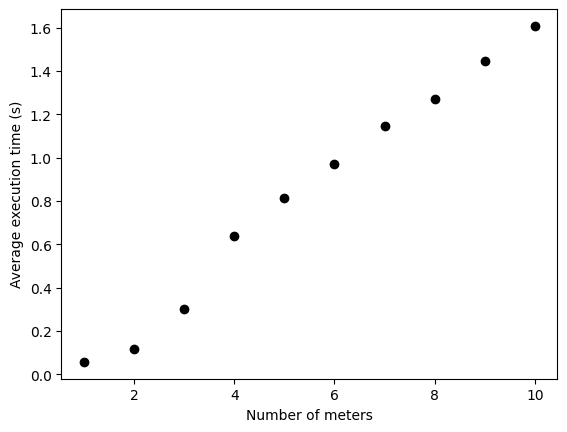

In [9]:
n_meters = np.arange(1, 11)
times = [benchmark(n, 100, 10) for n in n_meters]

fig, ax = plt.subplots(1, 1)
ax.plot(n_meters, times, "ko")
ax.set_xlabel("Number of meters")
ax.set_ylabel("Average execution time (s)")
plt.show()

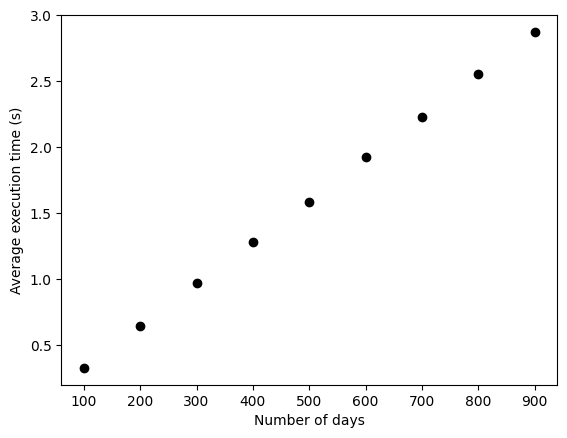

In [10]:
n_periods = np.arange(100, 1000, 100)
times = [benchmark(2, n, 10) for n in n_periods]

fig, ax = plt.subplots(1, 1)
ax.plot(n_periods, times, "ko")
ax.set_xlabel("Number of days")
ax.set_ylabel("Average execution time (s)")
plt.show()

My first observation of these results is that the cost calculation scales with O(n) for both the number of meters and number of days. This is already quite a good result in terms of scaling performance. To further reduce the calculation time, there are a few options that I would explore first:
- The function `rate_lookup` is the function that is being called the most often. Small improvements in this function could already significantly speed up the calculation. For that reason, I already shortly experimented with 2 different implementation (see comments in function). Since this function only contains a very little bit of code, I believe that it could be beneficial to investigate different data structures for the `rate_table`. This needs further investigation.
- The cost calculation could also strongly benefit from parallelization using a package like Dask. More specifically, I expect that calculating the rate for each row in the forecast_tabe would significantly improve in this manner.
- In the current format, each row in the `forecast_table` needs to search the entire `rate_table` for the correct rate. If we would know that everything is already sorted, lookups in `rate_table` could be significantly reduced by iterating the `forecast_table` in the following manner:
    - perform a normal rate lookup for the first entry, extract the part of the `rate_table` for the current period and meter (this part would only have a few rows with the different AQ windows). Save the starting date of the nex period in the `rate_table`.
    - go to the next row in the `forecast_table` and only update the section of the `rate_table` when the starting date of the new period is encountered.
    - repeat

These are just some suggestions. To be able to improve the calculation times properly, the current implementation needs to be profiled in detail to identify the largest bottlenecks. Afterwards, different implementations need to be tested in practice. Below is a quick profiling result that could serve as an example for a more detailed profiling study. This result indeed confirms my assumption that the majority of `total_cost_per_meter` is spent in `rate_lookup`.

In [11]:
import cProfile

cProfile.run("benchmark(4, 200)")

         2304719 function calls (2257970 primitive calls) in 3.128 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4    0.000    0.000    0.008    0.002 1493636905.py:1(total_consumption_per_meter)
      800    0.040    0.000    3.055    0.004 1717704962.py:1(rate_lookup)
        4    0.000    0.000    3.105    0.776 1717704962.py:32(total_cost_per_meter)
      800    0.002    0.000    3.073    0.004 1717704962.py:47(<lambda>)
        1    0.000    0.000    0.000    0.000 3097270448.py:1(generate_unique_ids)
        1    0.000    0.000    0.000    0.000 3097270448.py:10(<listcomp>)
        1    0.000    0.000    3.118    3.118 3097270448.py:113(<lambda>)
        1    0.000    0.000    0.002    0.002 3097270448.py:13(generate_random_meters)
        1    0.000    0.000    0.007    0.007 3097270448.py:44(generate_mock_consumption_data)
        1    0.000    0.000    3.118    3.118 3097270448.py:75(calculate_transportat